Some code fragments to help you start. Yoi will need to (obviously) set paths tp your own data area.

In [2]:
import pandas as pd
import numpy as np

# to get data from a FITS table
from astropy.io import fits
from astropy.table import Table

# to convert RA dec into actual form
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import FK5

The master catalog is based on the Revised Bologna Catalog and includes known GCs as well as obejct that have been thought to be GCs. We need GCs (1), extended GCs (8) and the galaxies (4)

     1 = globular cluster;
     2 = candidate globular cluster;
     3 = controversial object;
     4 = galaxy;
     5 = HII region
     6 = star(s)
     7 = asterism;
     8 = extended cluster;
     

In [14]:
master_catalog_df = pd.read_csv('master_catalog_sept_2024.csv')
master_catalog_df

,ID,RADEG,DECDEG,CLASS,DATATABLE
0,C1,0.157917,32.417778,2,di_tullio_zinn_13_table2
1,2M034,0.508375,51.606722,4,m31rbcV5
2,PAndAS-03,0.985042,40.888667,1,huxor14_table1
3,PAndAS-04,1.178875,47.361797,1,huxor14_table1
4,PAndAS-05,1.350625,43.926583,1,huxor14_table1
...,...,...,...,...,...
2266,C74,356.707917,45.247222,2,di_tullio_zinn_13_table2
2267,C75,357.170417,39.629167,2,di_tullio_zinn_13_table2
2268,SDSS18,357.290417,40.458333,4,di_tullio_zinn_13_table1
2269,PAndAS-01,359.300125,43.552300,1,huxor14_table1


Read in CFHT data of PandAS pointings

data from https://www.canfar.net/storage/list/PANDAS/PUBLIC


In [15]:
# load data of exposures from file in
# https://ws-sf.canfar.net/transfer/bmVpZ2g9U0ZVJnNpZ2V4cD0yMDIyMDcxMDE1MDc0NiZhcmM9Vk9TcGFjJmlkPTI0OTEwOTU0MCZ1c2VyPWFub25Vc2VyJm5zPVBBTkRBUyUyRlBVQkxJQyUyRkRPQ1MmbWV0aD1nZXQmYXV0aENvZGU9MCZydW5JRD1nOXNuZ2R2NnN1Z3E1ODNwJnVybD1odHRwJTNBJTJGJTJGc3Rvci1zZi0wMS5jYW5mYXIubmV0JTNBODg4OCUyRmFyY2hpdmUlMkY1ODA0MzQyYyUyRjE4ODklMkZ2b3NwYWMlMkZkZWZhdWx0JTJGMDAlMkYyNCUyRjcwJTJGMjQ5MTA5NTQwJTI1M0IlMjUzQjI3OTA0NDgzNw==-ZmlkPVRhYmxlMi50eHQmY2xuPTMwOTcyMiZjbWQ9MDQ4MWJjZWRlYWMwYjQ2ZTQxMDU3Y2I4YWUyMzg4OTQmbG1kPTE1Mzk3OTUxNzQ2NTM=-f7464048a902d90fb6fe371739d641b6/Table2.txt

pandas_obs_log = pd.read_csv('pandas_observing_log.txt',skiprows=35, header=None, delimiter=r"\s+")
col_names = ['obs_year','obs_month','obs_day','obs_hour','obs_min','obs_sec','mjd','RAh','RAm','RAs',\
         'DECd','DECm','DECs','ExpID','FieldID','OtherID','PID','Filter','Exp']
pandas_obs_log.columns = col_names
print(pandas_obs_log.head(2))

# concat coord columns into one string for astropy to use
pandas_obs_log['coord_string'] = pandas_obs_log['RAh'].astype(str)+' '+pandas_obs_log['RAm'].astype(str)+' '+ \
    pandas_obs_log['RAs'].astype(str)+' '+pandas_obs_log['DECd'].astype(str)+' '+pandas_obs_log['DECm'].astype(str)\
    +' '+pandas_obs_log['DECs'].astype(str)
                                                      
pandas_obs_log['coord_astropy'] = pandas_obs_log['coord_string'].apply(lambda x: SkyCoord(x, unit=(u.hourangle, u.deg)))
pandas_obs_log['coord_ra_deg'] = pandas_obs_log['coord_astropy'].apply(lambda x: x.ra.deg)
pandas_obs_log['coord_dec_deg'] = pandas_obs_log['coord_astropy'].apply(lambda x: x.dec.deg)

   obs_year  obs_month  obs_day  obs_hour  obs_min  obs_sec           mjd  \
0      2003          8       22        11       29    38.27  52873.478915   
1      2003          8       22        11       53    39.54  52873.495596   

   RAh  RAm   RAs  DECd  DECm  DECs   ExpID FieldID OtherID     PID    Filter  \
0    1   33  51.0    30    39  36.8  714745    m026    M33C  03BF15  g.MP9401   
1    1   33  51.0    30    39  36.8  714747    m026    M33C  03BF15  i.MP9701   

   Exp  
0  530  
1  660  


In [16]:
# group by field_id, the main way to identify a pointing,
# to then average the ra/dec form the various offset pointings
pandas_field_centres = pandas_obs_log.groupby('FieldID')[['coord_ra_deg','coord_dec_deg']].mean()

pandas_field_centres

,coord_ra_deg,coord_dec_deg
FieldID,,
m001,24.564181,27.638144
m002,23.464174,27.658144
m003,22.364174,27.938134
m004,24.564194,28.638148
m005,23.464194,28.658153
...,...,...
m402,8.127160,49.137894
m403,9.522208,49.736528
m404,5.188090,50.085593


In [17]:
# save pandas field centres
pandas_field_centres.to_csv('pandas_field_centres.csv')

<Axes: xlabel='coord_ra_deg', ylabel='coord_dec_deg'>

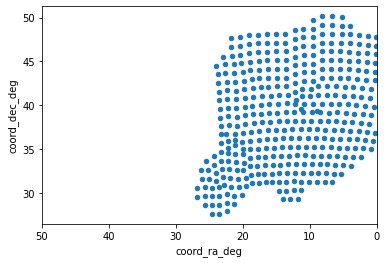

In [6]:
pandas_field_centres.plot.scatter(x='coord_ra_deg',y='coord_dec_deg',xlim=(50,0))


<Axes: xlabel='coord_ra_deg', ylabel='coord_dec_deg'>

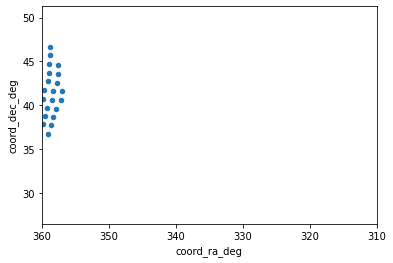

In [7]:
pandas_field_centres.plot.scatter(x='coord_ra_deg',y='coord_dec_deg',xlim=(360,310))


In [8]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Create SkyCoord objects for the master catalog and the pandas field centers
object_coords = SkyCoord(ra=master_catalog_df['RADEG'].values * u.deg,
                         dec=master_catalog_df['DECDEG'].values * u.deg,
                         frame='fk5')

In [9]:
field_coords = SkyCoord(ra=pandas_field_centres['coord_ra_deg'].values * u.deg,
                        dec=pandas_field_centres['coord_dec_deg'].values * u.deg,
                        frame='fk5')

In [10]:
# Use match_to_catalog_sky to find the closest field center for each object
idx, d2d, _ = object_coords.match_to_catalog_sky(field_coords)

In [11]:
# Collect the results
object_id = master_catalog_df['ID'].values
best_fit_pointing = pandas_field_centres.index.values[idx]  
min_dist = d2d.deg  # Minimum distances in degrees

Note that some object are not in any fields, and will have minimum distances greater than about 0.7 degs. Recall each field about 1x1 deg, so onject can be up to the to diagonal distance fom the centre - sqrt(0.5^2 + 0.5^2) ~0.7 

In [12]:
result_df = pd.DataFrame({
    'Object ID': object_id,
    'Nearest field': best_fit_pointing,
    'Distance to nearest field': min_dist
})
result_df.to_csv('result_new.csv')

In [13]:
result_df

,Object ID,Nearest field,Distance to nearest field
0,C1,m095,2.539979
1,2M034,m404,3.322483
2,PAndAS-03,m243,0.023986
3,PAndAS-04,m368,0.467914
4,PAndAS-05,m310,0.127090
...,...,...,...
2266,C74,m323,0.881098
2267,C75,m215,0.585970
2268,SDSS18,m238,0.189372
2269,PAndAS-01,m305,0.309150


Gets nearest fields for a specific class of objects

In [36]:
# Using master catalog:
    # Filter for specific class (1 (GCs),8 extended GC),4 (galaxy))
    # Make sure to store rad and dec
filtered_catalog_df = master_catalog_df[master_catalog_df['CLASS'] == 4]
filtered_catalog_df.head()

,ID,RADEG,DECDEG,CLASS,DATATABLE
1,2M034,0.508375,51.606722,4,m31rbcV5
5,2M035,1.549625,41.503722,4,m31rbcV5
7,C2,2.079167,34.468611,4,di_tullio_zinn_13_table2
8,C3,2.143750,34.627222,4,di_tullio_zinn_13_table2
18,2M031,4.089208,34.200056,4,m31rbcV5


In [37]:
from astropy.coordinates import SkyCoord
import astropy.units as u

# Create SkyCoord objects for the master catalog and the pandas field centers
object_coords = SkyCoord(ra=filtered_catalog_df['RADEG'].values * u.deg,
                         dec=filtered_catalog_df['DECDEG'].values * u.deg,
                         frame='fk5')

In [38]:
field_coords = SkyCoord(ra=pandas_field_centres['coord_ra_deg'].values * u.deg,
                        dec=pandas_field_centres['coord_dec_deg'].values * u.deg,
                        frame='fk5')

In [39]:
# Use match_to_catalog_sky to find the closest field center for each object
idx, d2d, _ = object_coords.match_to_catalog_sky(field_coords)

In [40]:
# Collect the results
object_id = filtered_catalog_df['ID'].values
raddeg = filtered_catalog_df['RADEG'].values
decdeg = filtered_catalog_df['DECDEG'].values
best_fit_pointing = pandas_field_centres.index.values[idx]  
min_dist = d2d.deg  # Minimum distances in degrees

In [41]:
result_df = pd.DataFrame({
    'Object ID': object_id,
    'RADEG': raddeg,
    'DECDEG': decdeg,
    'Nearest field': best_fit_pointing,
    'Distance to nearest field': min_dist
})
result_df.to_csv('result_G.csv')

Check if any are outside of the bounds of the fields

Find all the unique fields that these objects are found in

In [2]:
import pandas as pd
import numpy as np

# Load the three csv files
df1 = pd.read_csv('result_GC.csv')
df2 = pd.read_csv('result_G.csv')
df3 = pd.read_csv('result_EGC.csv')

# Get unique values
unique_field_ids1 = df1['Nearest field'].unique()
unique_field_ids2 = df2['Nearest field'].unique()
unique_field_ids3 = df3['Nearest field'].unique()

# Concatenate the unique values
unique_field_ids = np.concatenate((unique_field_ids1, unique_field_ids2, unique_field_ids3))

# Get unique values
unique_field_ids = np.unique(unique_field_ids)

# Order the unique values
unique_field_ids.sort()

# Output
print(unique_field_ids)
print(len(unique_field_ids))

# Print unique field IDs in chunks of 25
chunk_size = 25
for i in range(0, len(unique_field_ids), chunk_size):
    chunk = unique_field_ids[i:i + chunk_size]
    print(f"Chunk {i // chunk_size + 1}: {chunk}")

['m005' 'm011' 'm014' 'm020' 'm022' 'm024' 'm025' 'm033' 'm035' 'm037'
 'm043' 'm052' 'm058' 'm062' 'm070' 'm080' 'm082' 'm084' 'm085' 'm091'
 'm092' 'm094' 'm095' 'm097' 'm102' 'm111' 'm124' 'm125' 'm126' 'm138'
 'm142' 'm146' 'm148' 'm153' 'm161' 'm162' 'm165' 'm167' 'm168' 'm169'
 'm173' 'm180' 'm183' 'm184' 'm185' 'm186' 'm187' 'm188' 'm189' 'm196'
 'm204' 'm205' 'm206' 'm207' 'm208' 'm209' 'm210' 'm211' 'm212' 'm214'
 'm223' 'm224' 'm225' 'm227' 'm228' 'm229' 'm231' 'm232' 'm233' 'm234'
 'm235' 'm238' 'm240' 'm243' 'm248' 'm249' 'm253' 'm254' 'm255' 'm256'
 'm257' 'm261' 'm263' 'm265' 'm266' 'm267' 'm268' 'm269' 'm274' 'm275'
 'm276' 'm277' 'm278' 'm279' 'm280' 'm282' 'm285' 'm286' 'm293' 'm294'
 'm296' 'm297' 'm301' 'm303' 'm304' 'm305' 'm306' 'm307' 'm310' 'm316'
 'm317' 'm319' 'm321' 'm323' 'm327' 'm328' 'm333' 'm334' 'm335' 'm338'
 'm340' 'm341' 'm342' 'm348' 'm351' 'm362' 'm368' 'm375' 'm379' 'm390'
 'm391' 'm392' 'm395' 'm398' 'm402' 'm404']
136
Chunk 1: ['m005' 'm011' 'm014

Convert a fit file into its ccds

In [2]:
from astropy.io import fits
import os
import glob

# Define the input and output directories
input_dir = '../data/fit'
output_dir = '../data/ccd'

# Create the output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get a list of all FITS files in the input directory
fits_files = glob.glob(os.path.join(input_dir, '*.fit'))

# Loop over each FITS file
for fits_file in fits_files:
    print(f"Processing file: {fits_file}")
    try:
        # Open the FITS file
        hdul = fits.open(fits_file)

        # Get the base name of the input file without extension
        base_name = os.path.splitext(os.path.basename(fits_file))[0]

        # Loop through each HDU (Header/Data Unit) in the FITS file
        for i, hdu in enumerate(hdul):
            # Check if the HDU contains image data
            if isinstance(hdu, fits.ImageHDU) or isinstance(hdu, fits.PrimaryHDU) and i != 0:
                # Extract the data
                data = hdu.data
                # Save the data to a new FITS file
                output_filename = os.path.join(output_dir, f'{base_name}_ccd_{i}.fit')
                fits.writeto(output_filename, data, hdu.header, overwrite=True)
                print(f"Created: {output_filename}")

        # Close the FITS file
        hdul.close()

    except Exception as e:
        print(f"An error occurred while processing {fits_file}: {e}\n")

Processing file: ../data/fit\m005_g.fit
Created: ../data/ccd\m005_g_ccd_1.fit
Created: ../data/ccd\m005_g_ccd_2.fit
Created: ../data/ccd\m005_g_ccd_3.fit
Created: ../data/ccd\m005_g_ccd_4.fit
Created: ../data/ccd\m005_g_ccd_5.fit
Created: ../data/ccd\m005_g_ccd_6.fit
Created: ../data/ccd\m005_g_ccd_7.fit
Created: ../data/ccd\m005_g_ccd_8.fit
Created: ../data/ccd\m005_g_ccd_9.fit
Created: ../data/ccd\m005_g_ccd_10.fit
Created: ../data/ccd\m005_g_ccd_11.fit
Created: ../data/ccd\m005_g_ccd_12.fit
Created: ../data/ccd\m005_g_ccd_13.fit
Created: ../data/ccd\m005_g_ccd_14.fit
Created: ../data/ccd\m005_g_ccd_15.fit
Created: ../data/ccd\m005_g_ccd_16.fit
Created: ../data/ccd\m005_g_ccd_17.fit
Created: ../data/ccd\m005_g_ccd_18.fit
Created: ../data/ccd\m005_g_ccd_19.fit
Created: ../data/ccd\m005_g_ccd_20.fit
Created: ../data/ccd\m005_g_ccd_21.fit
Created: ../data/ccd\m005_g_ccd_22.fit
Created: ../data/ccd\m005_g_ccd_23.fit
Created: ../data/ccd\m005_g_ccd_24.fit
Created: ../data/ccd\m005_g_ccd_2

Experimenting the checking of if something is in range

In [14]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u

# Step 1: Load the FITS file and extract WCS
fits_file = '/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd35.fit'  # Replace with your FITS file path
with fits.open(fits_file) as hdulist:
    # Adjust the index if your image is not in the primary HDU
    header = hdulist[0].header
    data = hdulist[0].data

# Extract WCS information
wcs = WCS(header)

# Step 2: Define your sky coordinate (RA, Dec)
ra = 24.3  # Right Ascension in degrees
dec = 27.2    # Declination in degrees
sky_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

# Convert sky coordinate to pixel coordinate
# wcs.world_to_pixel returns (x_pixel, y_pixel)
x_pixel, y_pixel = wcs.world_to_pixel(sky_coord)

# Step 3: Check if pixel coordinates are within image bounds
# Image dimensions
naxis1 = header['NAXIS1']  # Width of the image
naxis2 = header['NAXIS2']  # Height of the image

# Function to check if pixel is within image bounds
def is_within_image(x, y, nx, ny):
    return (0 <= x < nx) and (0 <= y < ny)

if is_within_image(x_pixel, y_pixel, naxis1, naxis2):
    print("The sky coordinate is within the image.")
else:
    print("The sky coordinate is outside the image.")


The sky coordinate is outside the image.


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


In [15]:
! ls /Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd*

/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd1.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd10.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd11.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd12.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd13.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd14.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd15.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd16.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd17.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd18.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd19.fit
/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/m001_g_ccd2.fit
/Users/ahuxor/Astro_projects/G

In [2]:
import glob

# Example: Get all FITS files in a directory
fits_files = glob.glob('../data/m005_g_ccd*.fit')

If we order all the csvs, then just limit the csv based on what mxxx there are.
Code below, for one of the classes, go over all their ccds, if it is within said ccd, extract an image

In [6]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import astropy.units as u
import numpy as np
from astropy.visualization import ZScaleInterval
from PIL import Image
import glob
import os
import pandas as pd

# Define the input and output directories
input_dir = '../data/ccd'
output_dir = '../data/extended_cluster_cutouts'
os.makedirs(output_dir, exist_ok=True)

# Define the CSV file containing RA and Dec coordinates
csv_file = 'result_EGC.csv'

# Load the CSV file
df = pd.read_csv(csv_file)
ra_list = df['RADEG'].values
dec_list = df['DECDEG'].values

# Get a list of all FITS files in the input directory
fits_files = glob.glob(os.path.join(input_dir, '*.fit'))

# Function to check if pixel is within image bounds
def is_within_image(x, y, nx, ny):
    return (0 <= x < nx) and (0 <= y < ny)

# Function to convert FITS data to PNG with resampling
def fits_to_png(data, output_png, image_size=128, background_grey=94):
    # Replace NaNs or Infs with zeros to avoid issues
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # Apply Zscale normalization to raw data
    zscale = ZScaleInterval()
    vmin, vmax = zscale.get_limits(data)

    # Clip the data to the Zscale range
    clipped_data = np.clip(data, vmin, vmax)

    # Apply asinh scaling on the clipped data
    scaled_data = np.arcsinh(clipped_data)

    # Recompute the min/max for the asinh-transformed data
    scaled_vmin = scaled_data.min()
    scaled_vmax = scaled_data.max()

    # Normalize the scaled data to the range [0, 255] for 8-bit image representation
    scaled_data = (scaled_data - scaled_vmin) / (scaled_vmax - scaled_vmin)
    scaled_data = (scaled_data * 255).astype(np.uint8)

    # Replace black pixels (0 value) with the background grey value
    scaled_data[scaled_data == 0] = background_grey

    # Create an image using PIL
    img = Image.fromarray(scaled_data)

    # Resize the image if a specific size is provided
    if image_size is not None:
        img = img.resize((image_size, image_size), Image.LANCZOS)

    # Save the image as PNG
    img.save(output_png)

# Loop over each FITS file
for fits_file in fits_files:
    # print(f"Processing file: {fits_file}")
    try:
        # Load the FITS file and extract WCS
        with fits.open(fits_file) as hdulist:
            # Adjust the index if your image is not in the primary HDU
            header = hdulist[0].header
            data = hdulist[0].data

            # Extract WCS information
            wcs = WCS(header)

            # Image dimensions
            naxis1 = header['NAXIS1']  # Width of the image
            naxis2 = header['NAXIS2']  # Height of the image

            # Loop over each coordinate in the CSV file
            for ra, dec in zip(ra_list, dec_list):
                sky_coord = SkyCoord(ra=ra * u.deg, dec=dec * u.deg, frame='icrs')

                # Convert sky coordinate to pixel coordinate
                x_pixel, y_pixel = wcs.world_to_pixel(sky_coord)

                # Check if pixel coordinates are within image bounds
                if is_within_image(x_pixel, y_pixel, naxis1, naxis2):
                    print(f"The sky coordinate ({ra}, {dec}) is within the image.")

                    # Define the size of the cutout (e.g., 100x100 pixels)
                    cutout_size = (100, 100)  # (ny, nx)

                    # Create the cutout
                    cutout = Cutout2D(data, (x_pixel, y_pixel), cutout_size, wcs=wcs)

                    # Save the cutout as a PNG file
                    png_filename = os.path.join(output_dir, f'cutout_{os.path.basename(fits_file).replace(".fit", f"_{ra}_{dec}.png")}')
                    fits_to_png(cutout.data, png_filename)
                    print(f"Cutout saved to: {png_filename}")

    except Exception as e:
        print(f"An error occurred while processing {fits_file}: {e}")

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


Change image resolution

In [ ]:
import os
from PIL import Image

def resize_images(input_folder, output_folder, new_resolution):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(input_folder, filename)
            img = Image.open(img_path)
            img = img.resize((new_resolution, new_resolution), Image.ANTIALIAS)
            img.save(os.path.join(output_folder, filename))

input_folder = '../data/cutouts/cluster_cutouts'
output_folder = '../data/cutouts/downsample/cluster_cutouts'
new_resolution = 64

resize_images(input_folder, output_folder, new_resolution)

Create an image from a given location



Filename: /Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/individual_images/001_ccd1.fit
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       0 PrimaryHDU     829   (2158, 4689)   float32   
None
<SkyCoord (ICRS): (ra, dec) in deg
    (25.03395833, 27.95960833)>
[array(695.07090836), array(3550.50835852)]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]
the PROJPn keyword is deprecated, use PVi_ma. [astropy.wcs.wcs]


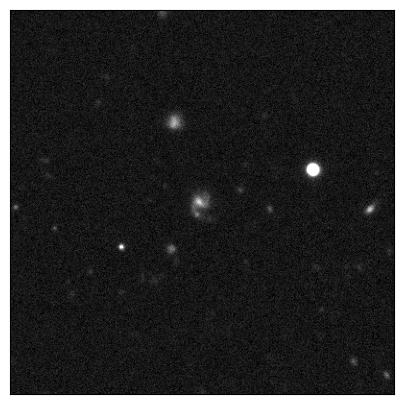

In [18]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
import astropy.units as u

# Load the FITS file
fits_image_filename = '/Users/ahuxor/Astro_projects/GC_detection_in_images/PandAS_data/individual_images/001_ccd1.fit'
hdulist = fits.open(fits_image_filename)
print(hdulist.info())

# Extract header and data from the primary HDU
header = hdulist['PRIMARY'].header
data = hdulist['PRIMARY'].data
hdulist.close()

# Create a WCS (World Coordinate System) object
wcs = WCS(header)

# Define the sky coordinate of the center
c0 = SkyCoord('01h40m08.15s', '+27d57m34.59s', frame='icrs')
print(c0)

# Convert sky coordinate to pixel coordinate
center = wcs.all_world2pix(c0.ra, c0.dec, 0)
print(center)

# Define the size of the cutout
size = 400  # pixels

# Create a cutout of the image around the specified center
cutout = Cutout2D(data, center, size, wcs=wcs)

# Plot the cutout image
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=cutout.wcs)
ax.imshow(cutout.data, cmap='gray', origin='lower', vmin=2000, vmax=2500)

# Remove axes labels
ax.set_xlabel('')
ax.set_ylabel('')

# Optionally, remove tick labels if desired
ax.coords[0].set_ticklabel_visible(False)  # RA axis
ax.coords[1].set_ticklabel_visible(False)  # Dec axis

# Optionally, remove the ticks themselves
ax.coords[0].set_ticks_visible(False)      # RA axis
ax.coords[1].set_ticks_visible(False)      # Dec axis
plt.savefig('bar.png')

plt.show()
